In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 15 
mpl.rcParams['ytick.labelsize'] = 15 

import matplotlib.pyplot as plt
from matplotlib import cm

import caffe

In [10]:
def vis_square(data, title, padsize=1, padval=0, grey=False):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(20,20))
    plt.axis('off')
    ax = plt.gca()
    im = ax.imshow(data)
    #plt.title(title, fontsize=20)
    #plt.colorbar(im, fraction=0.046, pad=0.04, fontsize=10)
    plt.show()

In [11]:
imX = 36
imY = 37
max_width = 227
max_height = 168
channels_number = 36

def _read_data_from_file(file_name):
    ''' This function reads a csv file to a numpy array and moves the 
    pixel coordinates to the top left corner.
    imX: index of imX in a row
    imY: index of imY in a row
    '''

    data = np.genfromtxt(file_name, delimiter=" ", dtype="float32")
    data[:, imX] -= min(data[:, imX])
    data[:, imY] -= min(data[:, imY])

    return data

def _prepare_data(data_2d):
    '''This function takes a 2D array (points X (channels+2)) 
    and converts it to 3D (channels X max_height X max_width)
    imX: index of imX in a row
    imY: index of imY in a row
    '''
    data_matrix = np.zeros((channels_number, max_height, max_width))
    for row in data_2d:
        i = row[imY]
        j = row[imX]
        data_matrix[:, i, j] = row[:channels_number]

    return data_matrix

In [12]:
caffe.set_mode_cpu()

In [13]:
net_200 = caffe.Net('/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/deploy.prototxt',
                '/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/snapshots/_iter_200000.caffemodel',
                caffe.TEST)

net_100 = caffe.Net('/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/deploy.prototxt',
                '/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/snapshots/_iter_10000.caffemodel',
                caffe.TEST)

net_20 = caffe.Net('/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/deploy.prototxt',
                '/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb/decrease_lr_all_inst_1601/snapshots/_iter_2000.caffemodel',
                caffe.TEST)

In [14]:
#transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

blob_t = caffe.proto.caffe_pb2.BlobProto()
data_t = open( '/home/noa/pcl_proj/experiments/mean_image_files/mean_image_training_fifth_10_rgb.binaryproto' , 'rb' ).read()
blob_t.ParseFromString(data_t)
arr_t = np.array(caffe.io.blobproto_to_array(blob_t))[0,:,:,:]

blob_t = caffe.proto.caffe_pb2.BlobProto()
data_t = open( '/home/noa/pcl_proj/experiments/mean_image_files/mean_image_training_fifth_10_hist.binaryproto' , 'rb' ).read()
blob_t.ParseFromString(data_t)
arr_hist = np.array(caffe.io.blobproto_to_array(blob_t))[0,:,:,:]

mean  = np.concatenate((arr_hist, arr_t))

In [15]:
net_200.blobs['data'].reshape(1, 3,168,227)
net_100.blobs['data'].reshape(1, 3,168,227)
net_20.blobs['data'].reshape(1, 3,168,227)

(3, 168, 227)


/mnt/antares_raid/home/noa/.virtualenvs/caffeEnv/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


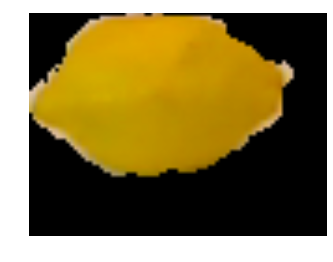

In [16]:
apple_2d = _read_data_from_file('/mnt/scratch/noa/pclproj/fpfh/lemon_1/lemon_1_1_5_fpfh.csv')
apple_3d =  _prepare_data(apple_2d)
apple = apple_3d[33:]
print apple.shape 
net_200.blobs['data'].data[...] =  apple - arr_t
out_200 = net_200.forward()

net_100.blobs['data'].data[...] =  apple - arr_t
out_100 = net_100.forward()

net_20.blobs['data'].data[...] =  apple - arr_t
out_20 = net_20.forward()

plt.axis('off')
plt.imshow(apple[:,:60,:80].transpose(1, 2,0) / 255)
plt.show()

In [17]:
out_200['prob'].argmax()

5

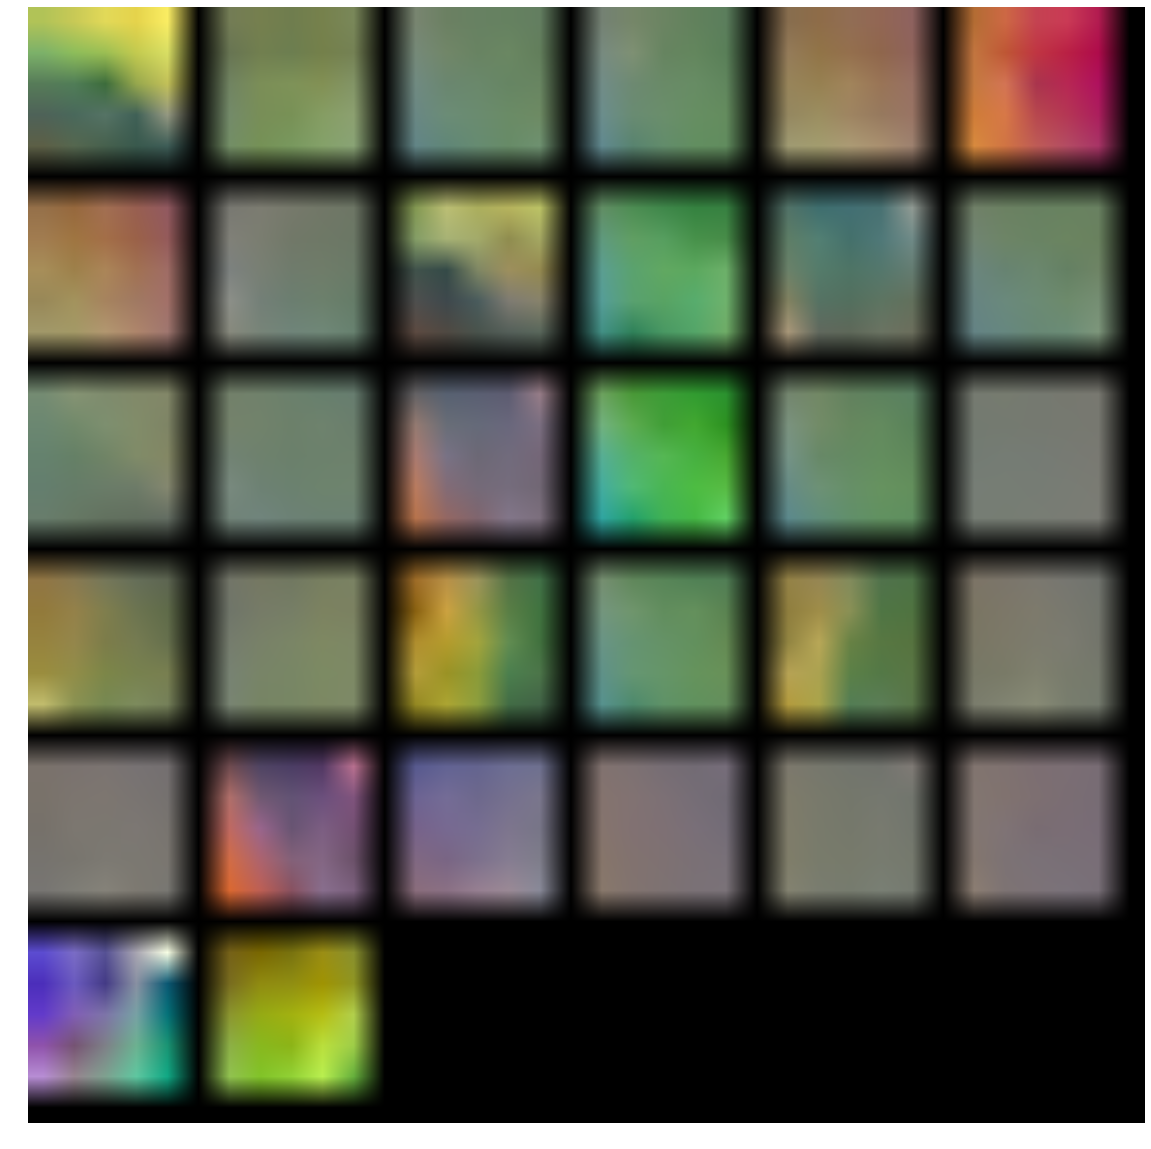

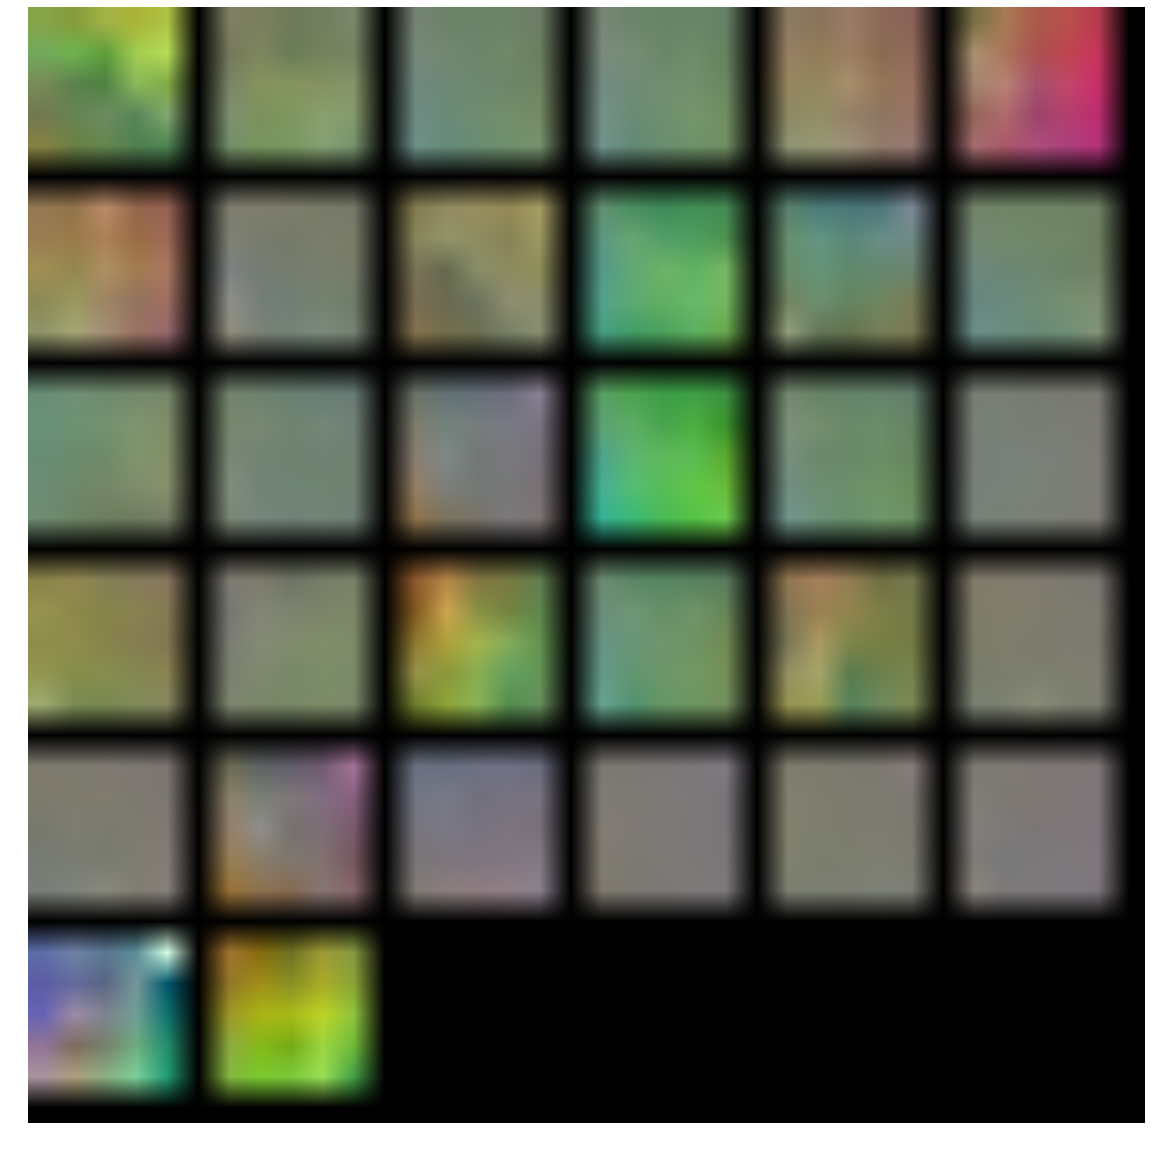

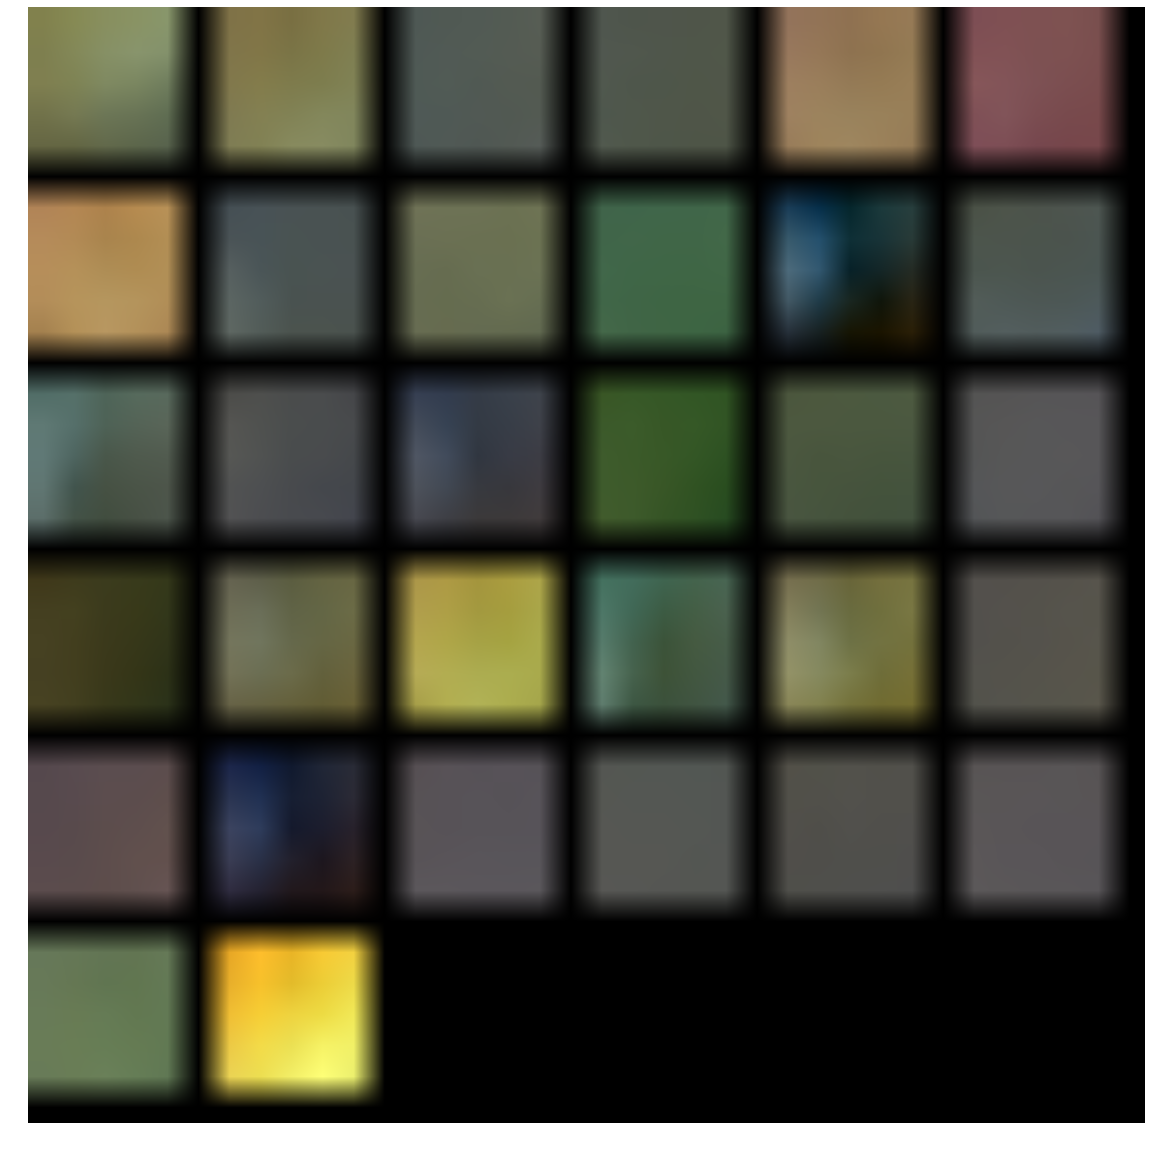

In [18]:
filters_200 = net_200.params['conv1'][0].data
vis_square(filters_200.transpose(0, 2, 3, 1), 'title')

filters_100 = net_100.params['conv1'][0].data
vis_square(filters_100.transpose(0, 2, 3, 1), 'title')

filters_20 = net_20.params['conv1'][0].data
vis_square(filters_20.transpose(0, 2, 3, 1), 'title')

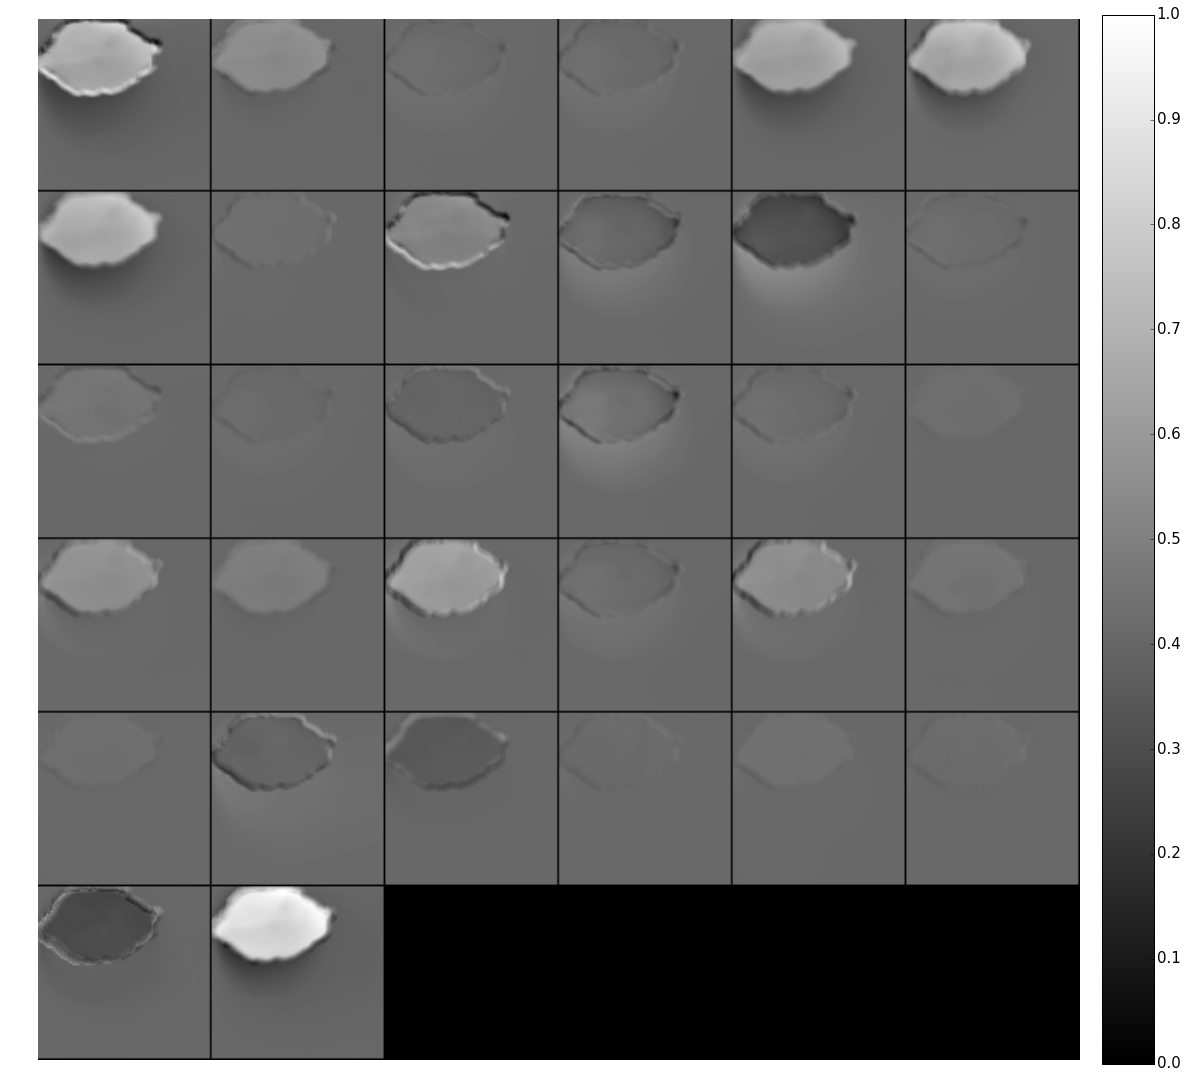

In [20]:
data = net_200.blobs['conv1'].data[0][:, :100, :100]
padsize=1
padval=0

data -= data.min()
data /= data.max()

# force the number of filters to be square
n = int(np.ceil(np.sqrt(data.shape[0])))
padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

# tile the filters into an image
data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
im = ax.imshow(data, cmap = cm.gray)
#plt.title('Response to filters. Network trained on RGB data.', fontsize=25)
plt.colorbar(im, fraction=0.047, pad=0.02)
plt.show()

In [84]:
def subPlotting(filters):
    fig2, axs2 = plt.subplots(8,4, figsize=(15, 8), facecolor='w', edgecolor='k')
    fig2.subplots_adjust(hspace = .02, wspace=.00000002)
    spines_to_remove = ['top', 'right', 'left', 'bottom']
    for k in range(32):
        axs2[k/4][k%4].set_axis_off()
        axs2[k/4][k%4].imshow(filters[k, :, :], cmap = cm.gray)
    plt.show()
    
def subPlotting_rgb(filters):
    fig2, axs2 = plt.subplots(8,4, figsize=(20, 30), facecolor='w', edgecolor='k')
    fig2.subplots_adjust(hspace = .1, wspace=.0002)
    for k in range(32):
        axs2[k/4][k%4].imshow(filters[k, :, :, :].transpose(1,2,0), cmap = cm.gray, interpolation='nearest')
    plt.show()

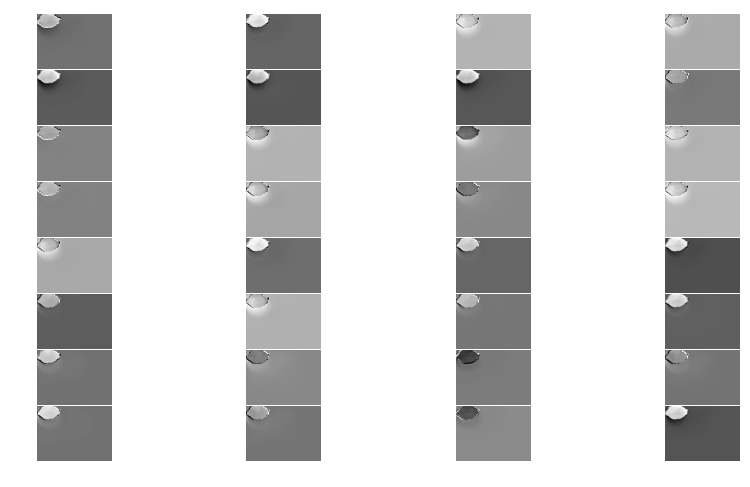

In [85]:
subPlotting(feat)

In [22]:
net_hist = caffe.Net('/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/histograms/decrease_lr_all_inst_1701/deploy.prototxt',
                '/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/histograms/decrease_lr_all_inst_1701/snapshots/_iter_200000.caffemodel',
                caffe.TEST)

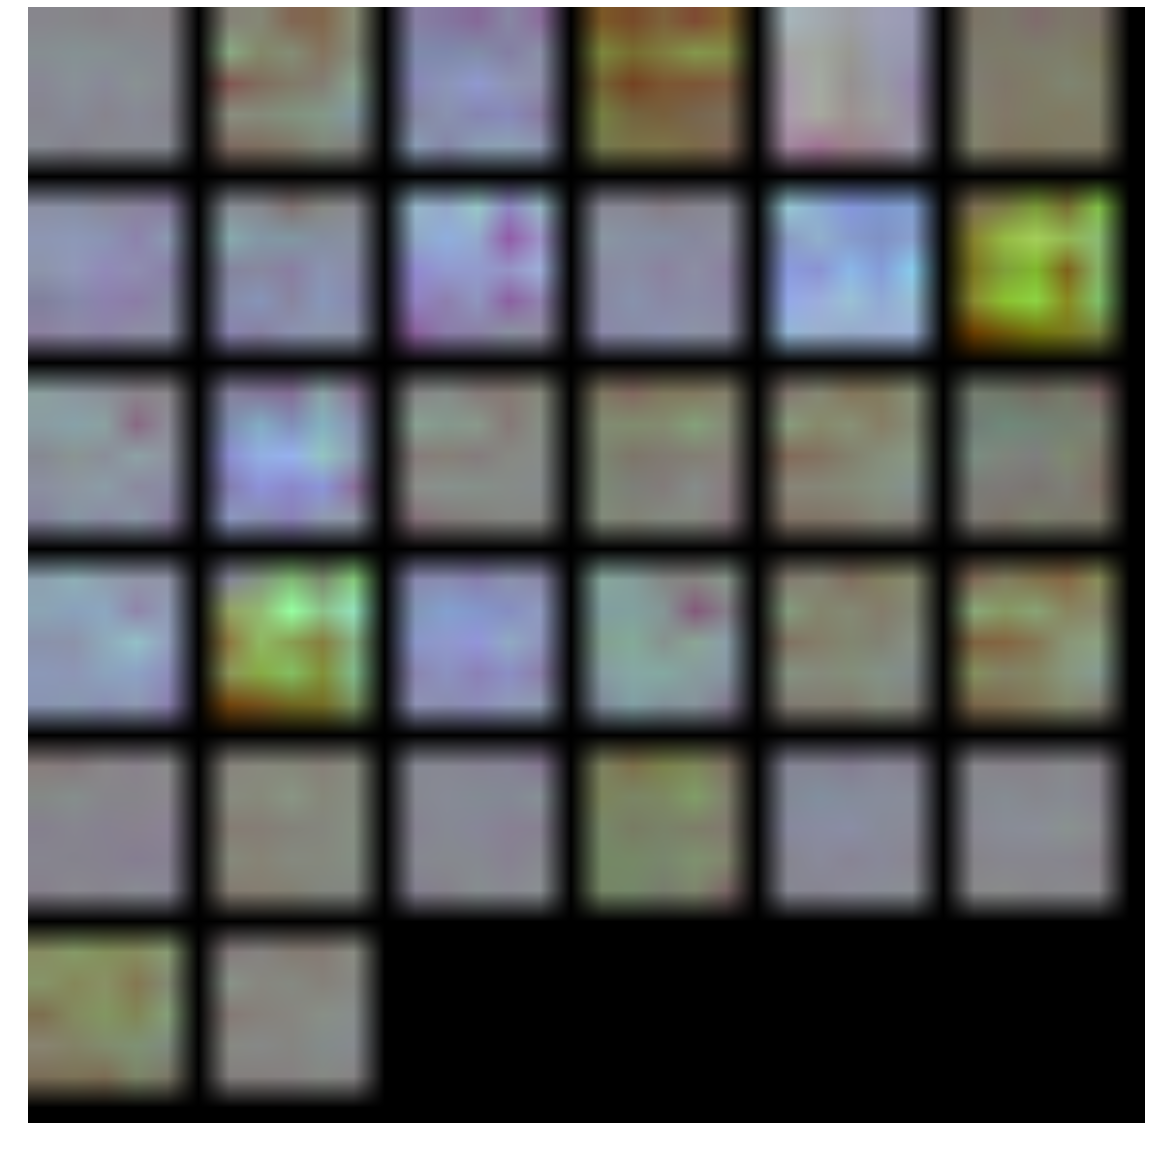

In [23]:
filters_hist = net_hist.params['conv1'][0].data
vis_square(filters_hist[:,0:3,:,:].transpose(0, 2, 3, 1), 'title')

/mnt/antares_raid/home/noa/.virtualenvs/caffeEnv/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


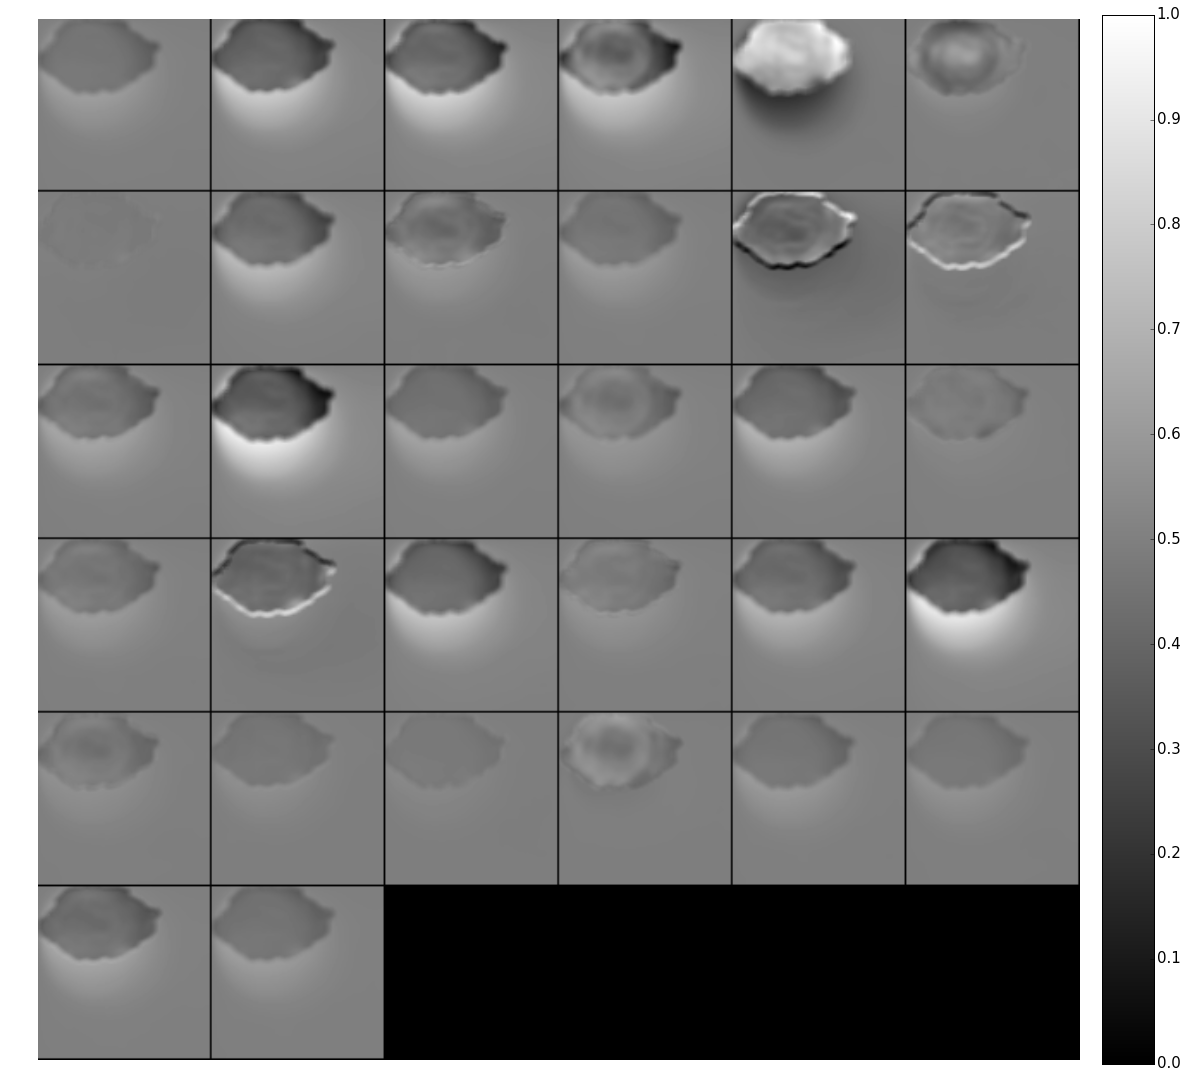

In [24]:
apple_2d = _read_data_from_file('/mnt/scratch/noa/pclproj/fpfh/lemon_1/lemon_1_1_5_fpfh.csv')
apple_3d =  _prepare_data(apple_2d)
apple = apple_3d
net_hist.blobs['data'].data[...] =  (apple - mean)[:33]
out = net_hist.forward()

data =  net_hist.blobs['conv1'].data[0][:, :100, :100]
padsize=1
padval=0

data -= data.min()
data /= data.max()

# force the number of filters to be square
n = int(np.ceil(np.sqrt(data.shape[0])))
padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

# tile the filters into an image
data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
im = ax.imshow(data, cmap = cm.gray)
#plt.title('Response to filters. Network trained on FPFH.', fontsize=25)
plt.colorbar(im, fraction=0.047, pad=0.02)
plt.show()

In [25]:
net_rgb_hist = caffe.Net('/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb_hist/decrease_lr_all_inst_1701/deploy.prototxt',
                '/home/noa/pcl_proj/experiments/cifar10/every_fifth_view/rgb_hist/decrease_lr_all_inst_1701/snapshots/_iter_200000.caffemodel',
                caffe.TEST)

/mnt/antares_raid/home/noa/.virtualenvs/caffeEnv/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


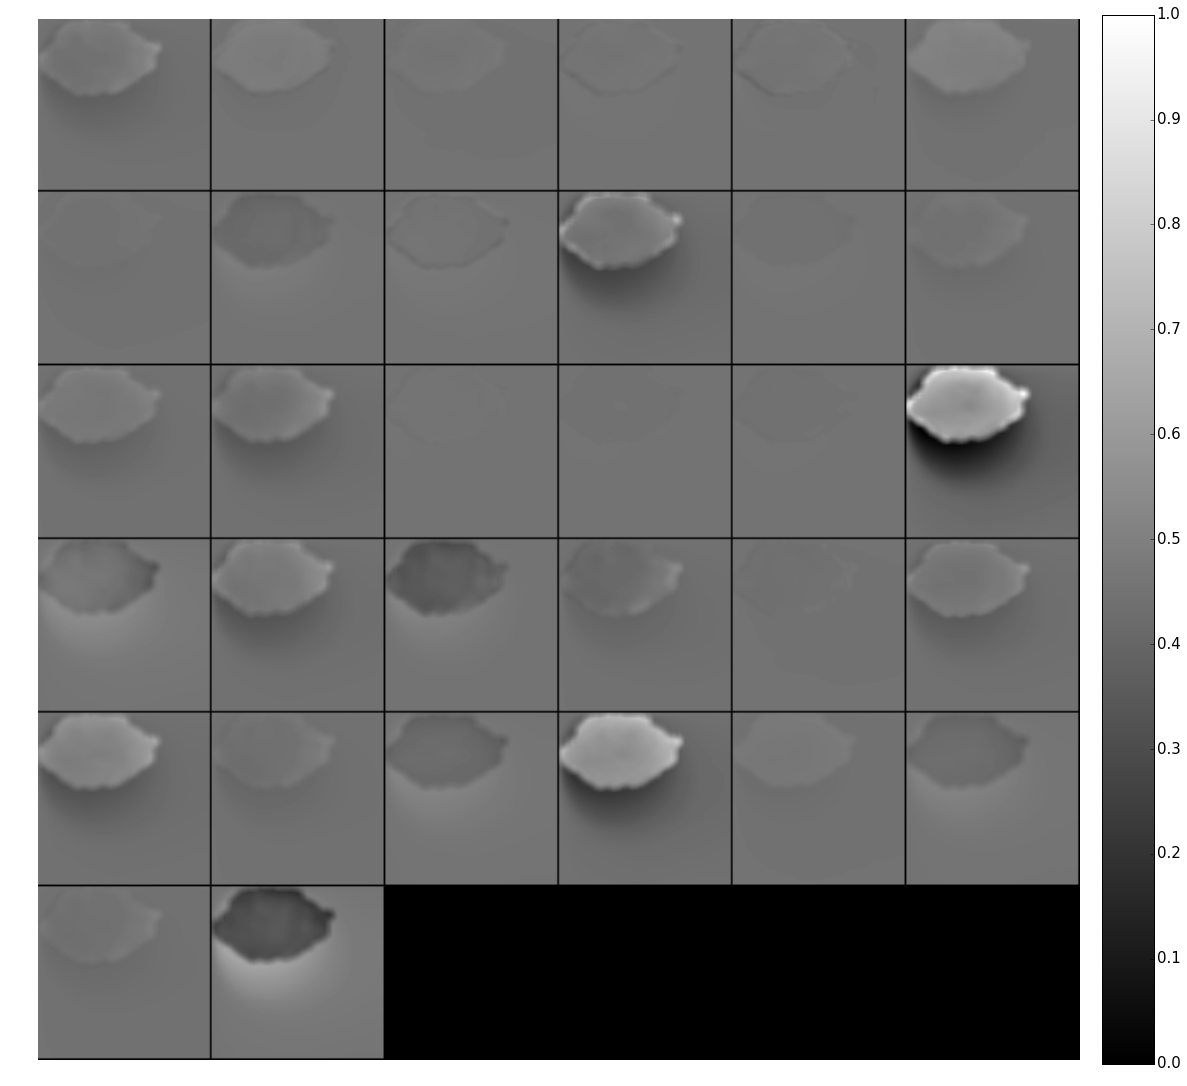

In [26]:
apple_2d = _read_data_from_file('/mnt/scratch/noa/pclproj/fpfh/lemon_1/lemon_1_1_5_fpfh.csv')
apple_3d =  _prepare_data(apple_2d)
apple = apple_3d
net_rgb_hist.blobs['data'].data[...] =  (apple - mean)
out = net_rgb_hist.forward()

data =  net_rgb_hist.blobs['conv1'].data[0][:, :100, :100]
padsize=1
padval=0

data -= data.min()
data /= data.max()

# force the number of filters to be square
n = int(np.ceil(np.sqrt(data.shape[0])))
padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

# tile the filters into an image
data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

plt.figure(figsize=(20,20))
plt.axis('off')
ax = plt.gca()
im = ax.imshow(data, cmap = cm.gray)
#plt.title('Response to filters. Network trained on FPFH+RGB.', fontsize=25)
plt.colorbar(im, fraction=0.047, pad=0.02)
plt.show()